In [17]:
import os
import tqdm
import json
import scipy.stats
import numpy as np
import pandas as pd
import ringity as rg
import networkx as nx
import itertools as it
import matplotlib.pyplot as plt

In [18]:
import importlib
importlib.reload(rg)

<module 'ringity' from '/home/joel/Desktop/ringity/ringity/__init__.py'>

In [19]:
def remove_selfloops(G):
    for u, v in G.edges():
        if u == v:
            G.remove_edge(u,v)

G_lipid = nx.read_gml("empirical_networks/lipid.gml")
G_lipid = G_lipid.subgraph(                                      # get lcc, in case threshold was chosen too high
                max(nx.connected_components(G_lipid), key=len)).copy()
remove_selfloops(G_lipid) 
G_lipid = nx.relabel_nodes(G_lipid, lambda x:str(x))

G_fibro = nx.read_gml("empirical_networks/fibro.gml")
G_fibro = G_fibro.subgraph(
            max(nx.connected_components(G_fibro), key=len)).copy()# get lcc, in case threshold was chosen too low
remove_selfloops(G_fibro)
G_fibro = nx.relabel_nodes(G_fibro, lambda x:str(x))

# 2c Immune Network
G_immune = nx.read_gml("empirical_networks/immune.gml")
remove_selfloops(G_immune)
G_immune = nx.relabel_nodes(G_immune, lambda x:str(x))

# 2d Circadian Network
G_genes = nx.read_gml("empirical_networks/gene_corrected.gml")
remove_selfloops(G_genes)

# 2e Soil Network
G_soil = nx.read_gml("empirical_networks/soil.gml")
remove_selfloops(G_soil)
G_soil = nx.relabel_nodes(G_soil, lambda x:str(x))

color_scheme = {"Jasmine":"#ffd07b",
                "Glaucous":"#577399",
                "Dark purple":"#412234",
                "Moss green":"#748e54",
                "Keppel":"#44bba4"
               }


color_dict = {
"immune":  color_scheme["Keppel"],
"fibro":   color_scheme["Glaucous"],
"gene":    color_scheme["Moss green"],
"lipid":   color_scheme["Jasmine"],
"soil":    color_scheme["Dark purple"],
"gene_alt":color_scheme["Moss green"]
}

    

In [20]:
# Dictionary to hold all  networks
networks = {
    "lipid": G_lipid, 
    "fibro": G_fibro,
    "immune": G_immune,
    "genes": G_genes,  # Uncomment if needed after processing
    "soil": G_soil
}

In [21]:
for name, G in networks.items():
    
    avg_degree = np.mean(list(dict(G.degree()).values()))
    avg_degree

    N = len(G.nodes())
    density = 2*G.size()/(N*(N-1))
    density 

    print(f"""
    name:{name}
    N:{N}
    density:{density}
    avg_degree:{avg_degree}

    """)




    name:lipid
    N:244
    density:0.2689738919247116
    avg_degree:65.36065573770492

    

    name:fibro
    N:403
    density:0.08476229275458934
    avg_degree:34.074441687344915

    

    name:immune
    N:180
    density:0.012849162011173185
    avg_degree:2.3

    

    name:genes
    N:7628
    density:0.01837361390126664
    avg_degree:140.13555322496066

    

    name:soil
    N:396
    density:0.13890806802199207
    avg_degree:54.86868686868687

    


In [25]:
def get_largest_component_with_positions(G, positions):
    # Find the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    
    # Subset the graph to the largest connected component
    G_largest = G.subgraph(largest_cc).copy()
    
    # Get the node indices for the largest component
    largest_cc_nodes = list(largest_cc)
    
    # Get the positions corresponding to the nodes in the largest component
    largest_positions = [positions[node] for node in largest_cc_nodes]
    
    return G_largest, largest_positions

folder = "figures/fitting_networks_to_rings/"

name = "our_model"

color= 'k'

N = 244
p = 0.26

if name == "erdos_renyi":
    
    color = 'k'

    true_positions = False
    network_type = "positionless"
    
    parameters = {"p":p}
    
    
    G = nx.erdos_renyi_graph(N,p)

    p_str = str(p).replace(".", "_")
    subfolder = f"network_{name}_N_{N}_p_{p_str}/"
    os.makedirs(folder+subfolder, exist_ok=True)
    
elif name == "our_model":
    
    true_positions = True
    
    beta=0.5+0.5*np.random.rand()
    r=0.5*np.random.rand()
    
    #G,positions = rg.network_model(300,density=0.01,beta=beta,r=r,return_positions=True)
    positions,G = rg.network_model(300,rho=0.01,beta=beta,a=r,return_positions=True)

    network_type = "positional"
    subfolder = f"network_model_N_{N}_density_{round(density*100)}_r_{round(r*100)}_beta_{round(beta*100)}/"
    os.makedirs(folder+subfolder, exist_ok=True)
    
    G, positions = get_largest_component_with_positions(G, positions)
    
    parameters = {"beta":beta,"r":r,"density":density}
    
    color = 'k'
    
else:
    
    true_positions = False
    
    G = networks[name]
    
    p_str = str(p).replace(".", "_")
    subfolder = f"network_{name}/"
    os.makedirs(folder+subfolder, exist_ok=True)
    
    color = color_dict[name]
    

G = G_lipid
#G = nx.configuration_model(list(dict(G_true.degree()).values()))




In [23]:
pwd

'/home/joel/Desktop/ringity'

In [ ]:

from ringity.network_fitting.retrieve_positions import PositionGraph
from ringity.network_fitting.fitting_model import FitNetwork

self = PositionGraph(G)
self.positions = positions

k = np.sqrt(2*np.pi/len(self.nodelist))
self.make_circular_spring_embedding(k = k,verbose=True)

    
    
    
self.smooth_neighborhood_widths()
self.recenter_and_reorient()
self.reconstruct_positions()


fitter = FitNetwork(self.G,
                self.rpositions
               )

100%|██████████| 300/300 [00:00<00:00, 588.61it/s]


ValueError: x and y must be the same size

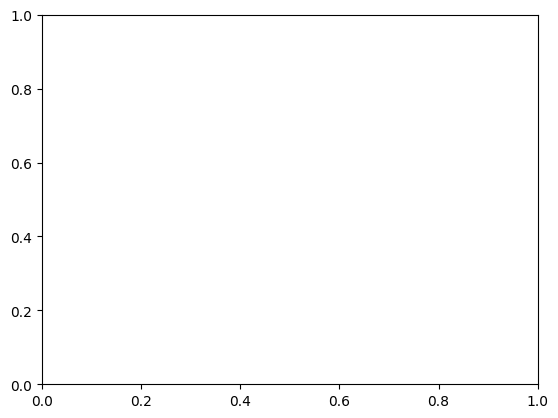

In [27]:
fontsize=20
if true_positions:
    
    fig,ax = plt.subplots()
    ax.scatter(positions,
            np.arctan2(self.pos[:,0], self.pos[:,1]), 
            c=color)
    
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
                      fontsize=fontsize)
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
                      fontsize=fontsize)
    
    ax.axis("equal")
    ax.axis("tight")
    
    plt.show()
fig.savefig(folder+subfolder+"fig_2_real.png")

In [28]:
avg_degree = np.mean(list(dict(self.G.degree()).values()))
avg_degree

N = len(self.nodelist)
density = 2*self.G.size()/(N*(N-1))
density

print(f"""


density:{density}
avg_degree:{avg_degree}

""")




density:0.2689738919247116
avg_degree:65.36065573770492




ValueError: x and y must be the same size

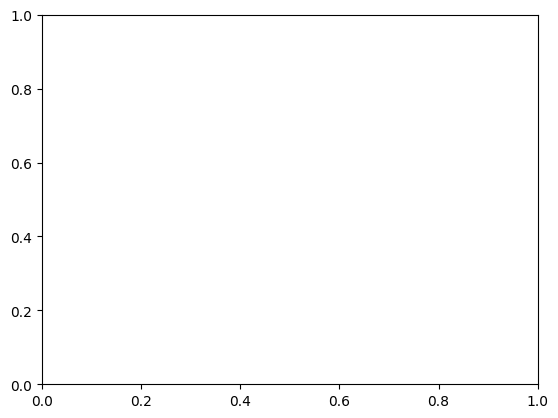

In [29]:
if true_positions:
    
    fig,ax = plt.subplots()
    ax.scatter(positions,
            [self.rpositions[i] for i in self.nodelist], 
            c=color)
    
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
                      fontsize=fontsize)
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
                      fontsize=fontsize)
    
    
    ax.axis("tight")
    plt.show()
fig.savefig(folder+subfolder+"fig_2_real.png")

In [30]:
color = 'k' 

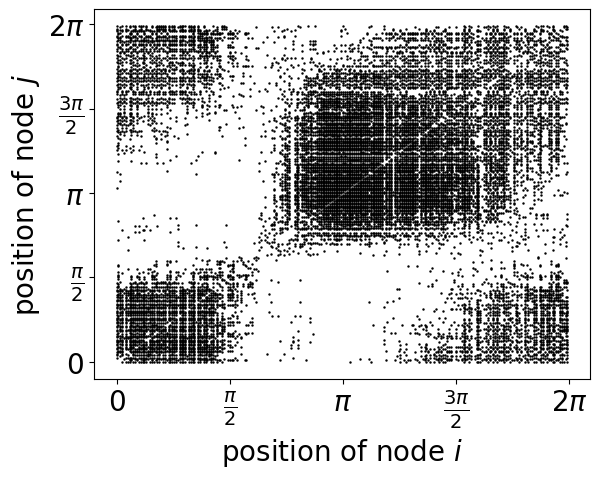

In [ ]:
def edge_points(ax, G, nodelist, p_dict,fontsize = 15):

    xy = np.array([[p_dict[i], p_dict[j]] for i,j in G.edges()])
    swap = np.vstack([xy[:,1],xy[:,0]]).T
    xy = np.vstack([xy,swap])

    n_nodes = len(nodelist)
    ax.scatter(xy[:,0], xy[:,1], c=color,s=50/np.sqrt(len(G.edges())))

    ax.set_xlabel(r"position of node $i$",
                  fontsize=fontsize
                 )

    ax.set_ylabel(r"position of node $j$",
                  fontsize=fontsize
                 )

    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
                      fontsize=fontsize)
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
                      fontsize=fontsize)
    
    
    
    






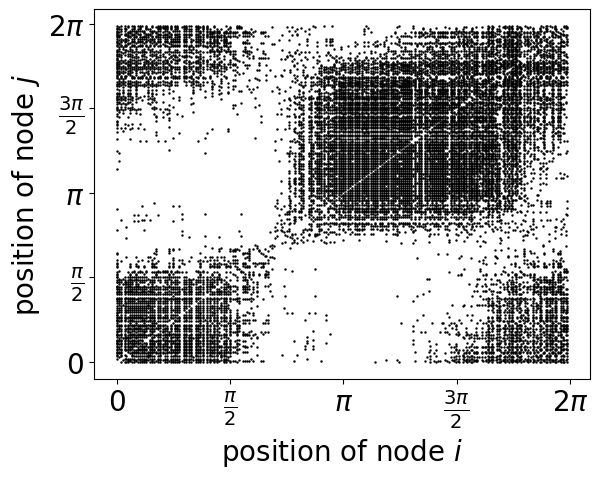

In [35]:
def save_figures(G,fitter,self):
    
    fig,ax = plt.subplots()
    edge_points(ax, self.G, self.nodelist, self.embedding_dict,fontsize=20)
    ax.axis("tight")
    fig.savefig(folder+subfolder+"fig_1_pos.png")

    fig,ax = plt.subplots()
    edge_points(ax, self.G, self.nodelist, self.rpositions,fontsize=20)
    ax.axis("tight")
    fig.savefig(folder+subfolder+"fig_2_pos.png")

    fig1 = fitter.links_by_distance()

    def slope_down(theta,c,w):
        temp = w-theta
        return c*0.5*(np.abs(temp)+temp)

    # [1:] because we want to avoid counting the absence of position_finder-loops
    p,_ = scipy.optimize.curve_fit(slope_down,
                                fitter.midpoints[1:],
                                50*(fitter.counts_neighbors/fitter.counts_total)[1:],
                                p0=None,
                                sigma=None
                                )

    fitter.c,fitter.w = p 
    fitter.c = fitter.c/50
    
    fig2 = fitter.neighbor_proportion()
    fig3 = fitter.draw_edge_edge_and_fit()

    fig1.savefig(folder+subfolder+"fig_1_fit.png")
    fig2.savefig(folder+subfolder+"fig_2_fit.png")
    fig3.savefig(folder+subfolder+"fig_3_fit.png")

    fig,ax = plt.subplots()
    ax.scatter((fitter.counts_neighbors/fitter.counts_total)[1:],
                slope_down(fitter.midpoints[1:], fitter.c, fitter.w),c='k',s=300)
    ax.set_xlabel("True Proportion")
    ax.set_ylabel("Fit Function")
    fig.savefig(folder+subfolder+"/goodness_of_fit.png")

    fig,ax = plt.subplots()
    ax.hist(self.rpositions.values(),density=True,color="k",bins=int(np.sqrt(len(self.rpositions.values()))));
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
                    fontsize=fontsize)

    ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.set_yticklabels([0, 0.1, 0.2, 0.3],
                    fontsize=fontsize)

    ax.set_xlabel("Position",fontsize=fontsize)
    ax.set_ylabel("Density",fontsize=fontsize)

    ax.axis("tight")
    fig,ax = plt.subplots()
    ax.scatter((fitter.counts_neighbors/fitter.counts_total)[1:],
                slope_down(fitter.midpoints[1:], fitter.c, fitter.w),c='k',s=300)
    ax.set_xlabel("True Proportion")
    ax.set_ylabel("Fit Function")
    fig.savefig(folder+subfolder+"/goodness_of_fit.png")

    fig,ax = plt.subplots()
    ax.hist(self.rpositions.values(),density=True,color="k",bins=int(np.sqrt(len(self.rpositions.values()))));
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
                    fontsize=fontsize)

    ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.set_yticklabels([0, 0.1, 0.2, 0.3],
                    fontsize=fontsize)

    ax.set_xlabel("Position",fontsize=fontsize)
    ax.set_ylabel("Density",fontsize=fontsize)

    ax.axis("tight")

    fig.savefig(folder+subfolder+"fig_3_fit.png")
    
    


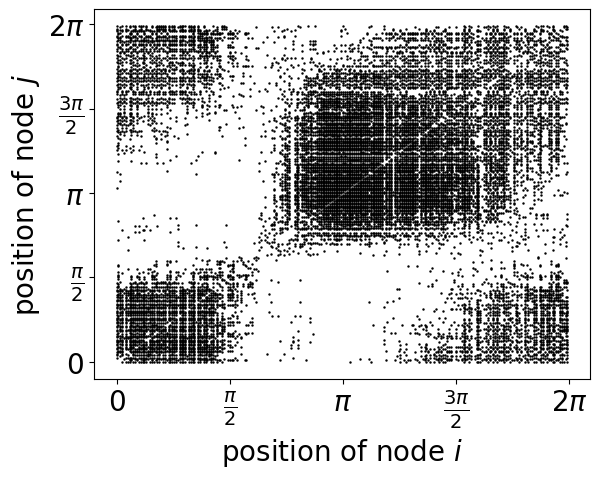

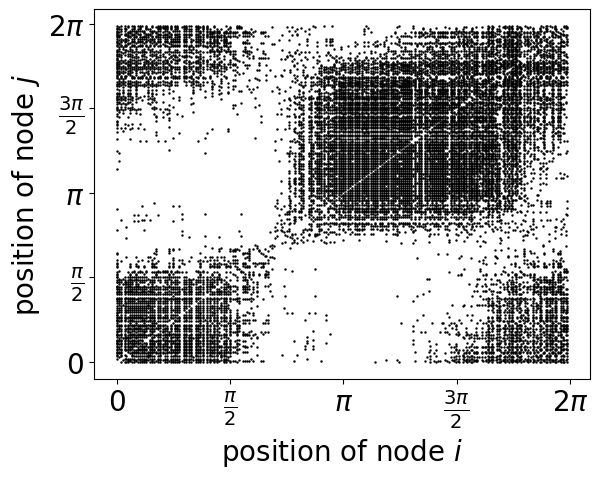

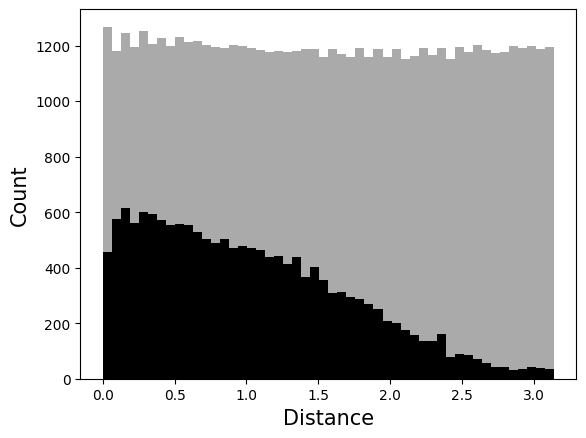

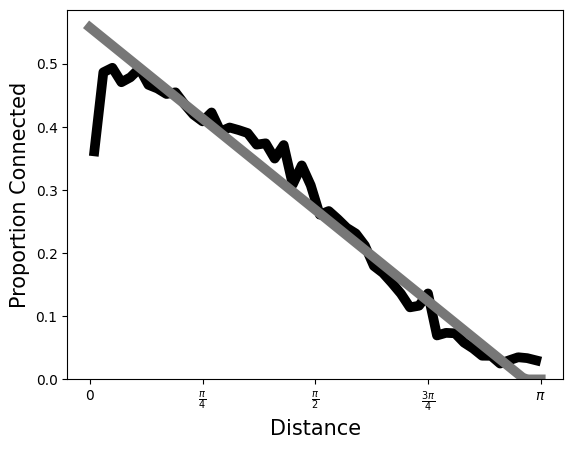

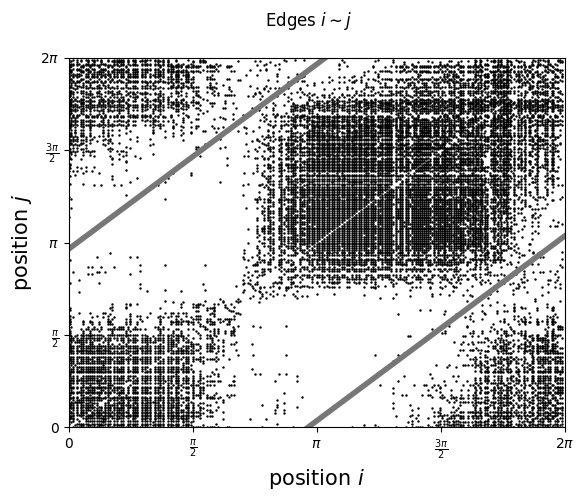

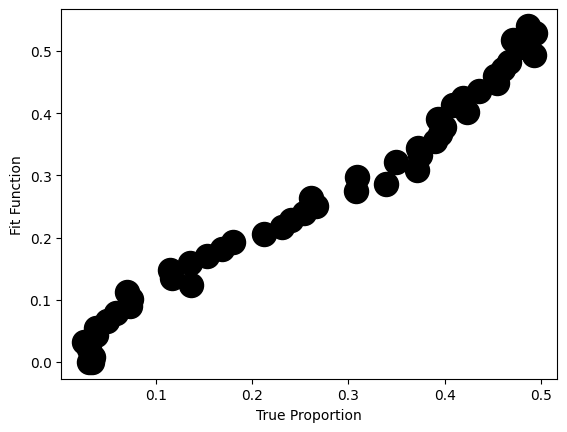

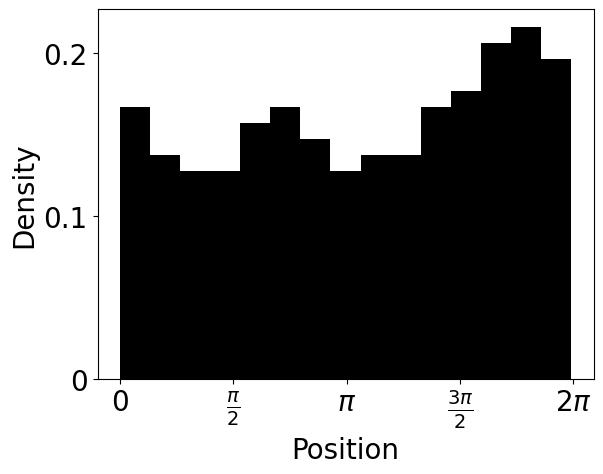

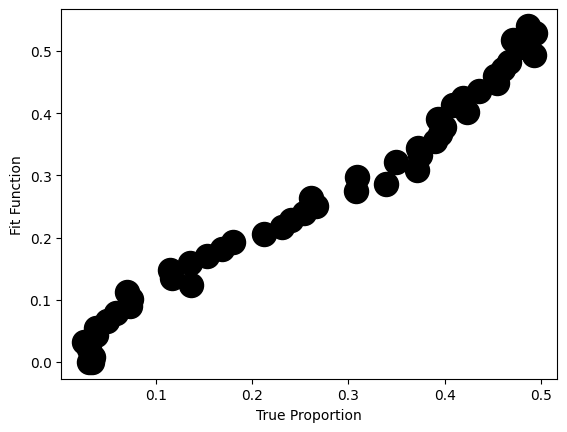

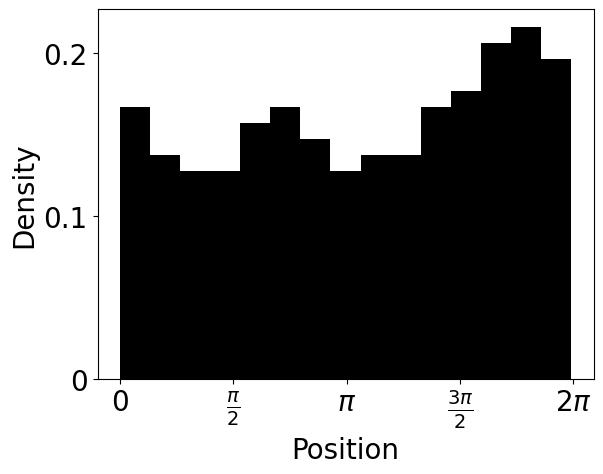

In [36]:
save_figures(G,fitter,self)

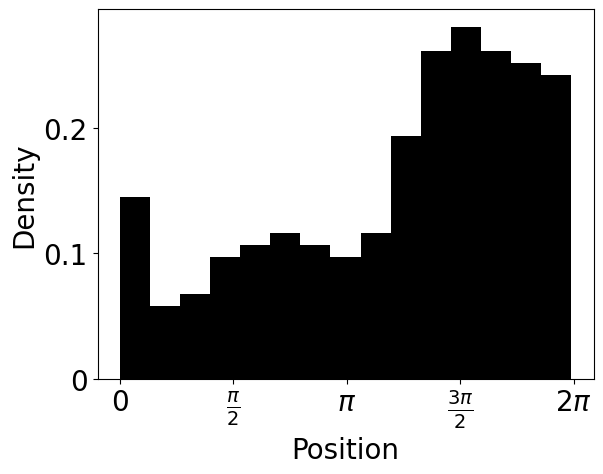

In [ ]:


def extract_and_save_info(folder, filename, G, parameters):



    N = len(G.nodes())
    density = 2*G.size()/(N*(N-1))
    avg_degree = np.mean(list(dict(G.degree()).values()))


    self = PositionGraph(G)
    k = np.sqrt(2*np.pi/len(self.nodelist))
    self.make_circular_spring_embedding(k = k,verbose=True)

    self.smooth_neighborhood_widths()
    self.recenter_and_reorient()
    self.reconstruct_positions()

    from fitting_model import FitNetwork



    def slope_down(theta,c,w):
        temp = w-theta
        return c*0.5*(np.abs(temp)+temp)



    fitter = FitNetwork(self.G,
                    self.rpositions
                   )

    fig1 = fitter.links_by_distance()


    p,_ = scipy.optimize.curve_fit(slope_down,
                                   fitter.midpoints[1:],
                                   50*(fitter.counts_neighbors/fitter.counts_total)[1:],
                                   p0=None,
                                   sigma=None
                                  )

    fitter.c,fitter.w = p 
    fitter.c = fitter.c/50


    save_values_to_json(folder, filename, density, avg_degree, N, parameters, fitter.c, fitter.w)


In [67]:
import json
import os

def save_values_to_json(folder, subfolder, density, avg_degree, N, parameters, fitter_c, fitter_w):
    """
    Saves the given values to a JSON file within the specified folder and subfolder structure.

    Args:
        folder (str): The name of the main folder.
        subfolder (str): The name of the subfolder.
        density (float): The density value.
        avg_degree (float): The average degree value.
        N (int): The N value.
        beta (float): The beta value.
        c (float): The c value.
        r (float): The r value.
        fitter_c (float): The fitter_c value.
        fitter_w (float): The fitter_w value.
    """

    # Create the folder structure if it doesn't exist
    folder_path = os.path.join(folder, subfolder)
    os.makedirs(folder_path, exist_ok=True)

    # Create the JSON file path
    file_path = os.path.join(folder_path, 'values.json')

    # Create a dictionary to store the values
    data = {
        "density": density,
        "avg_degree": avg_degree,
        "N": N,
        "parameters":parameters,
        "fitter_c": fitter_c,
        "fitter_w": fitter_w
    }

    # Write the dictionary to the JSON file
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)



save_values_to_json(folder, subfolder, density, avg_degree, N, parameters, fitter.c, fitter.w)